Data has been downloaded from: http://insideairbnb.com/get-the-data.html. The first step is to read the data and merge the two cities.  

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

amsterdam_data = pd.read_csv("data/listings_amsterdam.csv", index_col="id", low_memory=False)
amsterdam_data['city'] = "Amsterdam"
dublin_data    = pd.read_csv("data/listings_dublin.csv", index_col="id", low_memory=False)
dublin_data['city'] = "Dublin"

df = pd.concat([amsterdam_data,dublin_data])

We have over 20 thousand listings in Amsterdam and 9.5 thousand in Dublin.

In [11]:
df.city.value_counts()

Amsterdam    20025
Dublin        9437
Name: city, dtype: int64

Let start with having a look at the cleaning fees and the price per night. 

In [60]:
df[["price","cleaning_fee"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29462 entries, 2818 to 40377227
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         29462 non-null  object
 1   cleaning_fee  23307 non-null  object
dtypes: object(2)
memory usage: 690.5+ KB


It seems that price has no missing values, while the cleaning fee has over 6 thousand missing values. After checkig a few of the ads on the website, I concluded that the missing values can be interpreted as not charging a cleaning fee so they can be recoded to 0. Also, we need to get rid of the dollar sign (should be Euro actually) and convert the columns to floats. Also, I am creating a 'cleaning ratio' which is the cleaning fee divided by the price per night.

In [198]:
for var in ['price','cleaning_fee']:

    df[var] = df[var].replace({'\$':''}, regex=True)
    df[var] = df[var].replace({'\,':''}, regex=True).astype(float)

df['cleaning_fee'].fillna(0, inplace=True) 

df['cleaning_ratio'] = df.cleaning_fee / df.price


Lets see if the data have some outliers or other strange values.

In [123]:
df[['price','cleaning_fee','cleaning_ratio']].describe(percentiles=[.25,.5,.75,.9,.95,.99])

,price,cleaning_fee,cleaning_ratio
count,29462.000000,29462.000000,2.946100e+04
mean,152.986627,30.057668,inf
std,246.331262,29.812304,NaN
min,0.000000,0.000000,0.000000e+00
25%,81.000000,0.000000,0.000000e+00
50%,120.000000,30.000000,2.173913e-01
75%,175.000000,45.000000,3.333333e-01
90%,250.000000,60.000000,4.666667e-01
95%,350.000000,75.000000,5.714286e-01
99%,600.000000,125.000000,8.379888e-01


Seems like some of the listings have a price of 0 and some also have a quite extreme prices. Lets look more closely.

In [124]:
df[['price','cleaning_fee','cleaning_ratio']].sort_values(by='price').tail(5)

,price,cleaning_fee,cleaning_ratio
id,,,
34312752,8956.0,0.0,0.0
290701,9000.0,0.0,0.0
33730638,9000.0,0.0,0.0
286500,9000.0,0.0,0.0
34387298,22337.0,0.0,0.0


22 thousand euro per night seems like an error or at least an outlier. This listing will be removed.

In [133]:
df[['price','cleaning_fee','cleaning_ratio']].sort_values(by='cleaning_fee').tail()

,price,cleaning_fee,cleaning_ratio
id,,,
6655554,8915.0,500.0,0.056085
10328570,380.0,500.0,1.315789
2234543,600.0,500.0,0.833333
6149173,100.0,531.0,5.310000
13449518,3900.0,1000.0,0.256410


In [199]:
df = df.loc[(df.price < 9000) & (df.price != 0)]

Some cleaning fees look rather high and in some cases much higher than the price for one night. Most extreme is a 1000 Euro cleaning fee, but this is also for a listing with a price of 3900 per night.

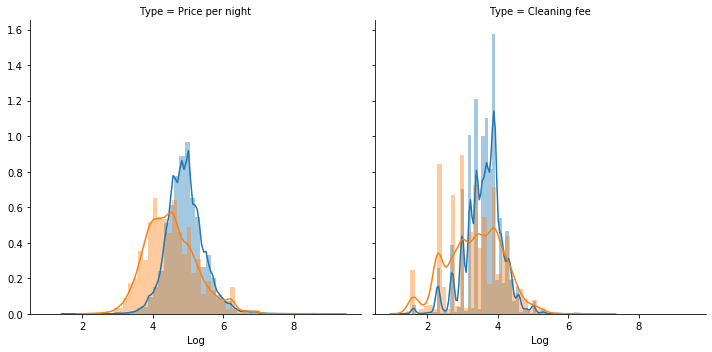

In [227]:
df['logprice'] = np.log(df.price)
df['logclean'] = np.log(df.cleaning_fee[df.cleaning_fee > 0])

df_plot = pd.melt(df[['logprice','logclean','city']], id_vars='city', var_name='Type', value_name='Log')
df_plot['Type'] = df_plot.Type.replace({'logprice': 'Price per night', 'logclean': 'Cleaning fee'}) 

plot = sns.FacetGrid(df_plot, hue='city', col='Type', height=5)
plot.map(sns.distplot,'Log')
plt.show()

Lets have a look at the distribution of the price and the cleaning fee by city

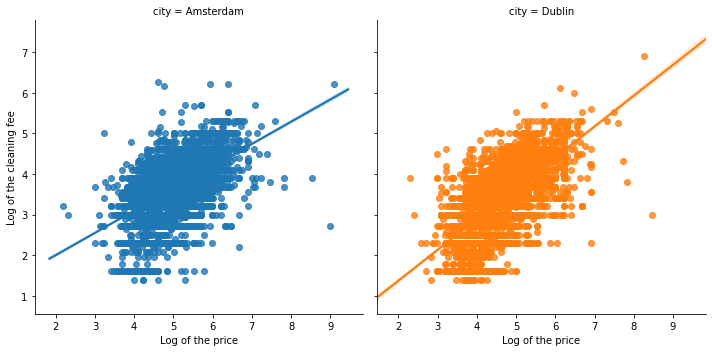

In [192]:
plot = sns.FacetGrid(df, col='city', hue='city', height=5)
plot.map(sns.regplot,'logprice','logclean')
plot.set_axis_labels("Log of the price", "Log of the cleaning fee")
plt.show()